# Task 3C - Advanced Analytics Engine:

I built this notebook to handle the math and machine learning backend for the CRM dashboard. It covers:
1. **Weighted Pipeline:** Calculating expected revenue.
2. **Sales Forecasting:** Predicting future sales.
3. **Risk Analysis:** Identifying stuck deals and predicting churn.
4. **Top Performers:** Ranking the sales agents.

In [14]:
# The necessary packages for this analysis engine.
import pandas as pd
import numpy as np
import joblib
import warnings
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# This suppresses warnings from the code, so that the output's cleaner.
warnings.filterwarnings('ignore')

## Step 1: Data Loading

First, I loaded the cleaned CSV files that the team prepared. I merged them all together so I could access the industry and region data in a single dataframe. I also made sure the dates were actually formatted as dates so the math wouldn't break later.

In [15]:
# Load the datasets
try:
    pipeline = pd.read_csv('cleaned_sales_pipeline.csv')
    accounts = pd.read_csv('cleaned_accounts.csv')
    teams = pd.read_csv('cleaned_sales_teams.csv')
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure cleaned_sales_pipeline.csv, cleaned_accounts.csv, and cleaned_sales_teams.csv are uploaded.")

# Rename columns for consistency if necessary
if 'sector' in accounts.columns:
    accounts = accounts.rename(columns={'sector': 'industry'})

# Merge pipeline with account details (industry, revenue) and agent details (regional office)
df = pipeline.merge(accounts[['account', 'industry', 'revenue']], on='account', how='left')
df = df.merge(teams[['sales_agent', 'regional_office']], on='sales_agent', how='left')

# Convert date columns to datetime objects
df['engage_date'] = pd.to_datetime(df['engage_date'], errors='coerce')
df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')
df['close_value'] = df['close_value'].fillna(0)

print(f"Data merged successfully. Total records: {len(df)}")
display(df.head())

Files loaded successfully.
Data merged successfully. Total records: 8800


,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,industry,revenue,regional_office
0,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,718.62,Central
1,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,3178.24,Central
2,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,718.62,Central
3,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,2714.90,Central
4,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,792.46,West


## Step 2: Weighted Pipeline Calculation

I implemented the weighted pipeline logic here. I assigned a probability to each stage (like 100% for Won, 50% for Engaging) and multiplied that by the deal value. This gives us a better "expected revenue" number than just summing everything up.

In [16]:
# Define probability weights for each stage
stage_probs = {
    'Won': 1.0,
    'Engaging': 0.5,
    'Prospecting': 0.1,
    'Lost': 0.0
}

# Apply probabilities
df['probability'] = df['deal_stage'].map(stage_probs).fillna(0)
df['weighted_amount'] = df['close_value'] * df['probability']

# Output the total weighted value
total_weighted = df['weighted_amount'].sum()
print(f"Total Weighted Pipeline Value: ${total_weighted:,.2f}")
display(df[['account', 'deal_stage', 'close_value', 'probability', 'weighted_amount']].head())

Total Weighted Pipeline Value: $10,404,138.00


,account,deal_stage,close_value,probability,weighted_amount
0,Cancity,Won,1054.0,1.0,1054.0
1,Isdom,Won,4514.0,1.0,4514.0
2,Cancity,Won,50.0,1.0,50.0
3,Codehow,Won,588.0,1.0,588.0
4,Hatfan,Won,517.0,1.0,517.0


## Step 3: Sales Forecasting

For forecasting, I used a Linear Regression model. I grouped the closed-won deals by month to see the trend, and then I used that to predict what the revenue looks like for the next 3 months. I saved this model so the dashboard can use it.

In [17]:
# Filter for Won deals only
won_deals = df[df['deal_stage'] == 'Won'].copy()

# Resample data to monthly frequency
monthly_sales = won_deals.resample('M', on='close_date')['close_value'].sum().reset_index()

# Create ordinal dates for regression analysis
monthly_sales['date_ordinal'] = monthly_sales['close_date'].apply(lambda x: x.toordinal())

X = monthly_sales[['date_ordinal']]
y = monthly_sales['close_value']

# Train Linear Regression model
forecast_model = LinearRegression()
forecast_model.fit(X, y)

# Predict for the next 3 months
last_date = monthly_sales['close_date'].max()
future_dates = [last_date + timedelta(days=30*i) for i in range(1, 4)]
future_X = [[d.toordinal()] for d in future_dates]
predictions = forecast_model.predict(future_X)

# Export results and save model
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Revenue': predictions})
forecast_df.to_csv('report_sales_forecast.csv', index=False)
joblib.dump(forecast_model, 'model_sales_forecast.pkl')

print("Forecast generated and model saved.")
display(forecast_df)

Forecast generated and model saved.


,Date,Predicted_Revenue
0,2018-01-30,1.002583e+06
1,2018-03-01,1.002946e+06
2,2018-03-31,1.003309e+06


## Step 4: Identifying At-Risk Accounts

I wrote a script to find accounts that are stuck. I defined "At Risk" as any high-value deal (above average) that has been open for more than 60 days. I exported this list so the sales team knows who to contact first.

In [18]:
# Calculate duration since engagement
current_date = df['close_date'].max()
active_deals = df[df['deal_stage'].isin(['Engaging', 'Prospecting'])].copy()
active_deals['days_open'] = (current_date - active_deals['engage_date']).dt.days

# Define thresholds
avg_deal_val = df[df['deal_stage'] == 'Won']['close_value'].mean()

# Filter for at-risk accounts
at_risk = active_deals[(active_deals['close_value'] > avg_deal_val) & (active_deals['days_open'] > 60)]

# Export report
at_risk_export = at_risk[['account', 'sales_agent', 'deal_stage', 'close_value', 'days_open']]
at_risk_export.to_csv('report_at_risk_accounts.csv', index=False)

print(f"Identified {len(at_risk)} at-risk accounts.")
display(at_risk_export)

Identified 0 at-risk accounts.


,account,sales_agent,deal_stage,close_value,days_open


## Step 5: Top Performers

I simply grouped the won deals by sales agent to see who brought in the most revenue. I sorted the list and exported it as a leaderboard.

In [19]:
# Group by agent and sum revenue
leaderboard = df[df['deal_stage'] == 'Won'].groupby('sales_agent')['close_value'].sum().sort_values(ascending=False).reset_index()
leaderboard.columns = ['Sales Agent', 'Total Revenue']

# Export report
leaderboard.to_csv('report_top_performers.csv', index=False)

print("Top Performer Report generated.")
display(leaderboard.head())

Top Performer Report generated.


,Sales Agent,Total Revenue
0,Darcel Schlecht,1153214.0
1,Vicki Laflamme,478396.0
2,Kary Hendrixson,454298.0
3,Cassey Cress,450489.0
4,Donn Cantrell,445860.0


## Step 6: Churn Risk Model

Finally, I built a Random Forest classifier to predict churn (lost deals). It looks at the deal value and the industry to calculate the probability of a deal being lost. I saved this model as a pickle file so it can be used on new data later.

In [20]:
# Prepare data: Filter for completed deals (Won or Lost)
ml_data = df[df['deal_stage'].isin(['Won', 'Lost'])].copy()
ml_data['target'] = ml_data['deal_stage'].apply(lambda x: 1 if x == 'Lost' else 0)

# Encode categorical data (Industry)
le = LabelEncoder()
ml_data['industry'] = ml_data['industry'].fillna('Unknown')
ml_data['industry_code'] = le.fit_transform(ml_data['industry'])

# Define features and target
features = ['close_value', 'industry_code']
X = ml_data[features].fillna(0)
y = ml_data['target']

# Train Random Forest model
churn_model = RandomForestClassifier(n_estimators=50, random_state=42)
churn_model.fit(X, y)

# Save the model
joblib.dump(churn_model, 'model_churn_risk.pkl')

print("Churn Risk Model trained and saved.")
display(ml_data.head())

Churn Risk Model trained and saved.


,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,industry,revenue,regional_office,probability,weighted_amount,target,industry_code
0,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,718.62,Central,1.0,1054.0,0,5
1,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,3178.24,Central,1.0,4514.0,0,4
2,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,718.62,Central,1.0,50.0,0,5
3,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,2714.90,Central,1.0,588.0,0,7
4,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,792.46,West,1.0,517.0,0,6


## Weighted Pipeline Overview

This chart shows how much potential revenue sits in each deal stage, weighted by the chance of closing. It highlights where most of our pipeline value is concentrated.

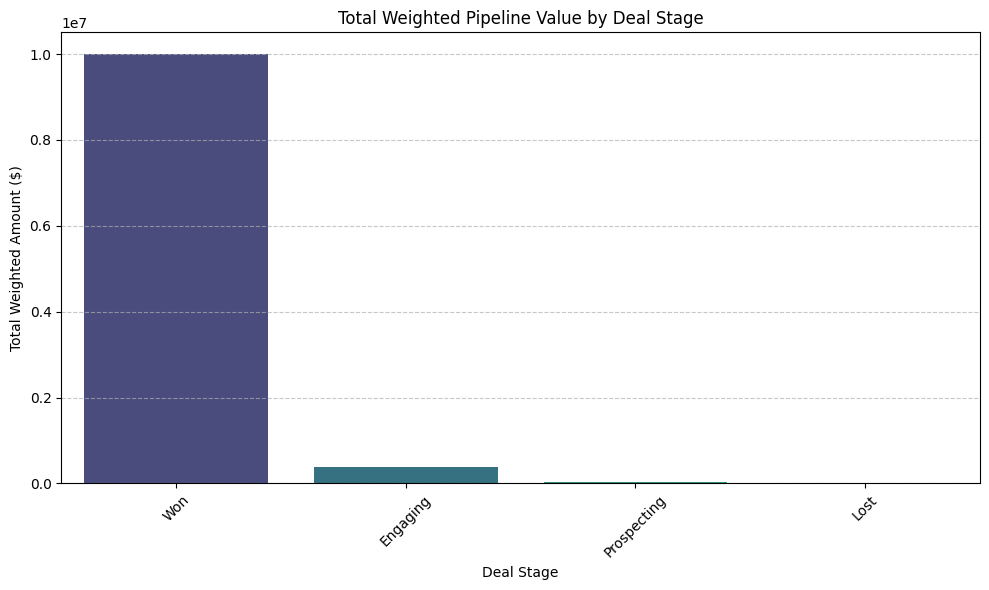

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by deal stage and sum the weighted amount
weighted_by_stage = df.groupby('deal_stage')['weighted_amount'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='deal_stage', y='weighted_amount', data=weighted_by_stage, palette='viridis')
plt.title('Total Weighted Pipeline Value by Deal Stage')
plt.xlabel('Deal Stage')
plt.ylabel('Total Weighted Amount ($)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Sales Forecast

This chart compares past monthly sales with predictions for the next three months, showing the overall trend.


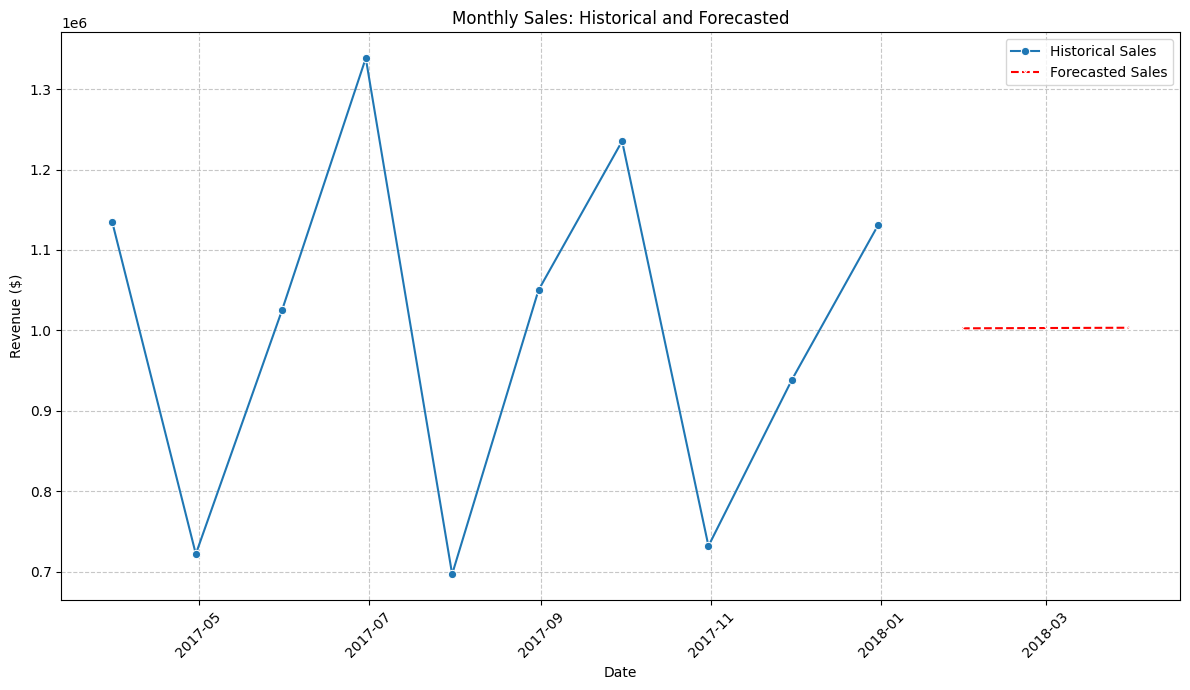

In [22]:
import matplotlib.dates as mdates

# Prepare data for plotting
historical_sales_plot = monthly_sales[['close_date', 'close_value']].rename(columns={'close_date': 'Date', 'close_value': 'Revenue'})
forecast_sales_plot = forecast_df.rename(columns={'Predicted_Revenue': 'Revenue'})

# Combine historical and forecasted data
combined_sales = pd.concat([
historical_sales_plot.set_index('Date'),
forecast_sales_plot.set_index('Date')
]).reset_index()

plt.figure(figsize=(12, 7))
sns.lineplot(x='Date', y='Revenue', data=historical_sales_plot, marker='o', label='Historical Sales')
sns.lineplot(x='Date', y='Revenue', data=forecast_sales_plot, marker='x', linestyle='--', color='red', label='Forecasted Sales')

plt.title('Monthly Sales: Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

## Top Performers

This chart highlights the top sales agents by total revenue, showcasing our leading performers.


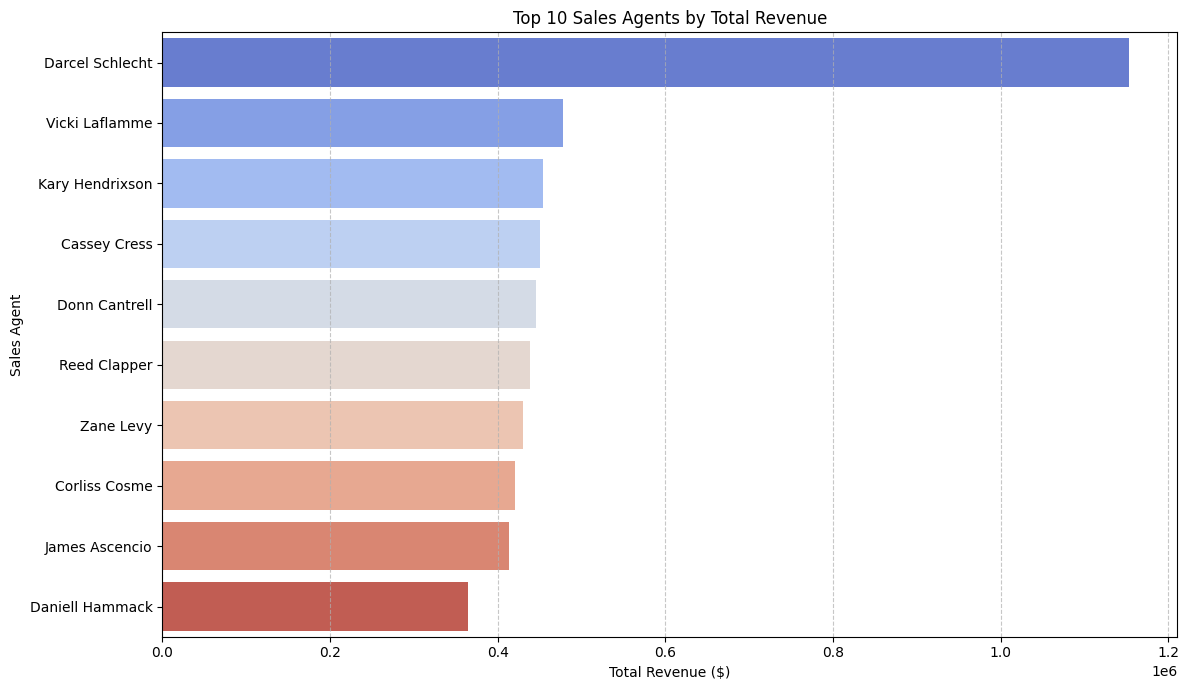

In [23]:
plt.figure(figsize=(12, 7))
sns.barplot(x='Total Revenue', y='Sales Agent', data=leaderboard.head(10), palette='coolwarm')
plt.title('Top 10 Sales Agents by Total Revenue')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Sales Agent')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()